In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-01-19 23:11
@Project  :   Hands-on Deep Learning with PyTorch-learning_of_neural_network
神经网络的学习
'''

# 导入所需的库
import random

import numpy as np
import pandas as pd
import torch
from ipywidgets import interact, fixed
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer as LBC
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision import transforms

得到了损失函数之后，就需要求出损失函数最小时对应的权重向量w，复杂模型的参数较多，需要使用迭代算法来逼近最小值。
## 1.深入认识梯度下降
![loss_func_demo](../assets/loss_func_demo.png)

梯度下降开始时，会随机设定初始权重，并从起始点开始，让w沿着损失减小最快的方向移动，每步的方向就是当前位置对应的梯度向量的反方向，每步的距离就是步长 * 当前位置所对应的梯度向量的大小（也就是梯度向量的模长），梯度向量的性质保证了沿着其反方向、按照其大小进行移动，就能够接近损失函数的最小值。
### 找出梯度向量的方向和大小
梯度向量是多元函数上，各个自变量的偏导数组成的向量，梯度向量中的具体元素就是各个自变量的偏导数，这些偏导数的具体值必须依赖于当前所在坐标点的值进行计算：
(1)梯度的大小和方向对每个坐标点而言是独一无二的，坐标点一旦变化，梯度向量的方向和大小也会变化；
(2)每走到一个新的点，将该点的坐标带入梯度向量的表达式进行计算，就可以得到当前点对应的梯度向量的方向和大小。
### 让坐标点移动起来（进行一次迭代）
权重向量的迭代公式：
$$\boldsymbol{w}_{(t+1)}=\boldsymbol{w}_{(t)}-\eta \frac{\partial L}{\partial \boldsymbol{w}_{(t)}}$$

从公式中可以看到，偏导数的大小影响整体梯度向量的大小，偏导数前的剪号影响整体梯度向量的方向。使用一个式子，就同时控制了大小和方向，可见**大道至简**。
一旦迭代 ，损失函数也会发生变化，可视化如下。

In [2]:
w1 = np.arange(-5, 15, 0.05)
w2 = np.arange(-10, 10, 0.05)
w1, w2 = np.meshgrid(w1, w2)

In [3]:
# 定义绘制三维图像的函数
def plot_3d(elev=45, azim=60, x=w1, y=w2):
    '''
    绘制三维图像
    :param elev: 上下旋转的角度
    :param azim: 水平旋转的角度
    :param x: x轴
    :param y: y轴
    :param z: z轴
    :return: None
    '''
    sse = (3 - x - y) ** 2 + (6 - 2 * x - y) ** 2  # 损失函数
    ax = plt.subplot(projection='3d')
    ax.plot_surface(x, y, sse, cmap='rainbow', alpha=0.7)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('w1', fontsize=10)
    ax.set_ylabel('', fontsize=10)
    ax.set_zlabel("sse", fontsize=10)


# 调用
interact(plot_3d, elev=[0, 15, 30], azim=(-180, 180), x=fixed(w1), y=fixed(w2))
plt.show()

interactive(children=(Dropdown(description='elev', options=(0, 15, 30), value=0), IntSlider(value=60, descript…

## 2.找出距离和方向——反向传播
### 初步认识反向传播
在进行梯度下降时，需要得到当前位置的梯度向量，过程中最大的难点就在于获得梯度向量的表达式。一个2层的二分类神经网络的的梯度（导数）计算过程如下：
![2_layer_grad_compute](../assets/2_layer_grad_compute.png)

可以看到，对$w^{(1 \rightarrow 2)}$和$w^{(0 \rightarrow 1)}$的求导过程很长、很复杂，此时需要利用链式法则对复杂网络求导过程进行简单化：
$$\frac{\partial u}{\partial w}=\frac{\partial u}{\partial z} * \frac{\partial z}{\partial w}$$

其中， 函数u=h(z)、z=f(w)，且两个函数在各自自变量的定义域上都可导。
对链式法则的感性认识：当一个函数是由多个函数嵌套而成，最外层函数向最内层自变量求导的值，等于外层函数对外层自变量求导的值与内层函数对内层自变量求导的值的乘积。
使用链式法则求解梯度：
$$\frac{\partial \text { Loss }}{\partial w^{(1 \rightarrow 2)}} =\sigma^{(1)}\left(\sigma^{(2)}-y\right) \\
\frac{\partial \text { Loss }}{\partial w^{(0 \rightarrow 1)}}=\left(\sigma^{(2)}-y\right) * w^{1 \rightarrow 2} *\left(\sigma^{(1)}\left(1-\sigma^{(1)}\right)\right) * X$$

可以看到，计算出来的表达式非常简单，同时所有的变量都是在正向传播中已经计算好或输入模型的变量。求解导数时是从左向右、从输出向输入，逐渐往前，并且所使用的节点上的张量，也是从后向前逐渐用到，这和我们正向传播的过程完全相反，这种从左到右、不断使用正向传播中的元素对梯度向量进行计算的方式，就是**反向传播**。
### PyTorch实现反向传播
在梯度下降中，每走一步都需要更新梯度，计算量巨大，PyTorch已经实现了自动计算梯度，有两种方式实现梯度计算：
- autograd.grad()：使用torch.autograd.grad()函数计算出损失函数上具体某个点/某个变量的导数，适用于单层神经网络
- backward()：对于深层神经网络，需要一次性计算大量权重对应的导数值，并且这些权重是以层为单位组织成权重矩阵，可以直接使用PyTorch提供的基于autograd的反向传播功能损失的backward()方法来进行计算
    需要注意，在实现反向传播之前，首先要完成模型的正向传播，并且要定义损失函数。

In [4]:
# 1.AutoGrad计算梯度
x = torch.tensor(2., requires_grad=True)
y = x ** 2
torch.autograd.grad(y, x)

(tensor(4.),)

In [5]:
y = torch.randint(2, size=(1,))
z = x ** 2 + 2 * x - 3
sigma = z.sigmoid()
loss = -(y * sigma.log() + (1 - y) * (1 - sigma).log())
torch.autograd.grad(loss, x)

(tensor(5.9598),)

In [6]:
# 构造数据
X = torch.randn((500, 20)) * 100
y = torch.randint(3, size=(500,))
X.shape, y.shape

(torch.Size([500, 20]), torch.Size([500]))

In [7]:
# 2.backward()
# 定义模型
class Model(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 13, bias=False)
        self.linear2 = nn.Linear(13, 8, bias=False)
        self.output = nn.Linear(8, out_features, bias=False)

    def forward(self, x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        z_hat = self.output(sigma2)
        return z_hat

In [8]:
# 实例化模型
input_dim = X.shape[1]
output_dim = y.unique().sum().int().item()
model = Model(input_dim, output_dim)
model  # 输出模型的结构

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=False)
  (linear2): Linear(in_features=13, out_features=8, bias=False)
  (output): Linear(in_features=8, out_features=3, bias=False)
)

In [9]:
# 前向传播
z_hat = model(X)
z_hat.shape

torch.Size([500, 3])

In [10]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()
loss = criterion(z_hat, y)
loss

tensor(1.1353, grad_fn=<NllLossBackward0>)

In [11]:
# 查看权重和梯度
model.linear1.weight[0], model.linear1.weight.grad

(tensor([-0.0049,  0.0229, -0.0828,  0.1596,  0.0724,  0.0471,  0.1874,  0.0747,
          0.0457,  0.2163,  0.0612, -0.0009,  0.0977, -0.0329, -0.2020, -0.1641,
          0.2143,  0.0130, -0.0695, -0.0362], grad_fn=<SelectBackward0>),
 None)

In [12]:
# 反向传播、计算梯度
loss.backward()

In [13]:
# 重新查看，权重未更新、梯度更新
model.linear1.weight[0], model.linear1.weight.grad[0]

(tensor([-0.0049,  0.0229, -0.0828,  0.1596,  0.0724,  0.0471,  0.1874,  0.0747,
          0.0457,  0.2163,  0.0612, -0.0009,  0.0977, -0.0329, -0.2020, -0.1641,
          0.2143,  0.0130, -0.0695, -0.0362], grad_fn=<SelectBackward0>),
 tensor([-4.0165e-03,  1.2522e-02, -1.2325e-02, -1.0145e-02, -9.9331e-03,
         -2.0769e-02,  1.5413e-04,  2.6265e-02, -1.7333e-02, -4.4034e-03,
          5.6439e-03,  2.5885e-03,  2.5273e-02, -8.9707e-03,  1.1992e-02,
          1.9955e-02,  2.6359e-03,  4.3577e-05,  9.2752e-03,  9.0639e-03]))

In [14]:
# loss.backward()：RuntimeError，不能重复执行，要想重复执行，需指定retain_graph参数为True用于保存计算图，只能有效保存一次
z_hat = model(X)
loss = criterion(z_hat, y)
loss.backward(retain_graph=True)
loss.backward()

在使用autograd的时候，定义张量需要指定requires_grad参数为True，但在定义打包好的类以及使用loss.backward()的时候，却
没有给任何数据定义requires_grad=True，这是因为：
- 当使用nn.Module继承后的类进行正向传播时，权重w是自动生成的，在生成时就被自动设置为允许计算梯度（requires_grad=True），所以不需要手动去设置。
- 特征张量X与真实标签y都不在反向传播的过程当中，但是它们都是损失函数计算需要用的值，backward函数是通过下面的方式判断哪些张量需要求解梯度：首先backward值会识别叶子节点，不在叶子上的变量是不会被backward考虑的；对于全部叶子节点来说，只有属性requires_grad=True的节点，才会被计算。因此在设置X与y时，没有设置requires_grad参数，默认让“允许求解梯度”为False，所以backward在计算的时候就只会计算关于权重w的部分。

## 3.移动坐标点——Optim
### 走出第一步
根据反向传播得到了梯度向量，就有了大小和方向，接下来我们就可以开始走出第一步。

In [15]:
lr = 5  # 步长，即学习率，一般小于1
w = model.linear1.weight.data  # 当前的权重
dw = model.linear1.weight.grad  # 当前的梯度
w[0], dw[0]

(tensor([-0.0049,  0.0229, -0.0828,  0.1596,  0.0724,  0.0471,  0.1874,  0.0747,
          0.0457,  0.2163,  0.0612, -0.0009,  0.0977, -0.0329, -0.2020, -0.1641,
          0.2143,  0.0130, -0.0695, -0.0362]),
 tensor([-0.0120,  0.0376, -0.0370, -0.0304, -0.0298, -0.0623,  0.0005,  0.0788,
         -0.0520, -0.0132,  0.0169,  0.0078,  0.0758, -0.0269,  0.0360,  0.0599,
          0.0079,  0.0001,  0.0278,  0.0272]))

In [16]:
# w(t+1) = w(t) - α * grad
# 更新第1次
w -= lr * dw
w[0], dw[0]

(tensor([ 0.0554, -0.1649,  0.1020,  0.3117,  0.2214,  0.3586,  0.1851, -0.3193,
          0.3057,  0.2824, -0.0234, -0.0398, -0.2813,  0.1016, -0.3819, -0.4634,
          0.1747,  0.0124, -0.2086, -0.1721]),
 tensor([-0.0120,  0.0376, -0.0370, -0.0304, -0.0298, -0.0623,  0.0005,  0.0788,
         -0.0520, -0.0132,  0.0169,  0.0078,  0.0758, -0.0269,  0.0360,  0.0599,
          0.0079,  0.0001,  0.0278,  0.0272]))

In [17]:
# 更新第2次，实际上不能这么操作，因为权重与梯度是同步更新的
w -= lr * dw
w[0], dw[0]

(tensor([ 0.1156, -0.3528,  0.2869,  0.4639,  0.3704,  0.6701,  0.1828, -0.7133,
          0.5657,  0.3484, -0.1081, -0.0786, -0.6604,  0.2362, -0.5618, -0.7628,
          0.1352,  0.0117, -0.3478, -0.3081]),
 tensor([-0.0120,  0.0376, -0.0370, -0.0304, -0.0298, -0.0623,  0.0005,  0.0788,
         -0.0520, -0.0132,  0.0169,  0.0078,  0.0758, -0.0269,  0.0360,  0.0599,
          0.0079,  0.0001,  0.0278,  0.0272]))

In [18]:
# 更新第3次
lr = 0.1
w -= lr * dw
w[0], dw[0]

(tensor([ 0.1168, -0.3565,  0.2906,  0.4670,  0.3734,  0.6763,  0.1827, -0.7211,
          0.5709,  0.3498, -0.1098, -0.0794, -0.6680,  0.2389, -0.5654, -0.7687,
          0.1344,  0.0117, -0.3505, -0.3108]),
 tensor([-0.0120,  0.0376, -0.0370, -0.0304, -0.0298, -0.0623,  0.0005,  0.0788,
         -0.0520, -0.0132,  0.0169,  0.0078,  0.0758, -0.0269,  0.0360,  0.0599,
          0.0079,  0.0001,  0.0278,  0.0272]))

### 从第一步到第二步：动量法Momentum
普通梯度下降就是在重复正向传播、计算梯度、更新权重的过程，但这个过程往往非常漫长，学习率设置得特别小时会更漫长，只有当学习率设置得非常巨大，才能够看到一些改变，但巨大的学习率可能会跳过真正的最小值，所以无法将步长设置得很大，无论如何，梯度下降都是一个缓慢的过程。此时可以通过使用动量Momentum来加速迭代。动力图示如下：
![momentum_demo](../assets/momentum_demo.png)

其中，对上一步的梯度向量加上的权重被称为动量参数（也叫做衰减力度，通常使用γ进行表示），对这一点的梯度向量加上的权重就是步长（依然表示为η），真实移动的向量为$v_t$，即称为动量（Momentum）。对应公式如下：
$$\begin{aligned}
v_{(t)} & =\gamma v_{(t-1)}-\eta \frac{L}{\partial \boldsymbol{w}} \\
\boldsymbol{w}_{(t+\mathbf{1})} & =\boldsymbol{w}_{(t)}+v_{(t)}
\end{aligned}$$

此时$v{t-1}$代表了之前所有步骤所累积的动量和，梯度下降的方向有了“惯性”，受到历史累计动量的影响：当新坐标点的梯度反方向与历史累计动量的方向一致时，历史累计动量会加大实际方向的步子；当新坐标点的梯度反方向与历史累计动量的方向不一致时，历史累计动量会减小实际方向的步子。
### 动量法的手动实现

In [19]:
lr = 0.1
gamma = 0.9
w = model.linear1.weight.data  # 当前的权重
dw = model.linear1.weight.grad  # 当前的梯度
w.shape, dw.shape

(torch.Size([13, 20]), torch.Size([13, 20]))

In [20]:
# 第1步
v = torch.zeros_like(dw)  # v(0)
v = gamma * v - lr * dw  # v(t) = gamma * v(t-1) - lr * dw
w += v  # w(t+1) = w(t) + v(t)
w[0]

tensor([ 0.1180, -0.3603,  0.2943,  0.4700,  0.3764,  0.6826,  0.1827, -0.7290,
         0.5761,  0.3511, -0.1115, -0.0801, -0.6756,  0.2416, -0.5690, -0.7747,
         0.1336,  0.0117, -0.3533, -0.3135])

In [21]:
# 第2步
v = gamma * v - lr * dw
w += v
w[0]

tensor([ 0.1203, -0.3674,  0.3013,  0.4758,  0.3820,  0.6944,  0.1826, -0.7440,
         0.5860,  0.3536, -0.1147, -0.0816, -0.6900,  0.2467, -0.5758, -0.7861,
         0.1321,  0.0117, -0.3586, -0.3187])

In [22]:
# 第3步
v = gamma * v - lr * dw
w += v
w[0]

tensor([ 0.1236, -0.3776,  0.3114,  0.4840,  0.3901,  0.7113,  0.1825, -0.7654,
         0.6000,  0.3572, -0.1193, -0.0837, -0.7105,  0.2540, -0.5856, -0.8023,
         0.1300,  0.0117, -0.3662, -0.3261])

可以看到，加入了动量之后，权重的更新更加明显，即**动量可以加速圈中的迭代**，即使设置较小的学习率，也能看到权重的明显变化。
### torch.optim实现带动量的梯度下降
PyTorch库的架构中拥有专门实现优化算法的模块`torch.optim`可以实现带动量的梯度下降。

In [23]:
# 一、准备阶段
# 数据和超参
X.shape, y.shape, lr, gamma

(torch.Size([500, 20]), torch.Size([500]), 0.1, 0.9)

In [24]:
# 实例化模型
model = Model(input_dim, output_dim)
model, model.linear1.weight[0]

(Model(
   (linear1): Linear(in_features=20, out_features=13, bias=False)
   (linear2): Linear(in_features=13, out_features=8, bias=False)
   (output): Linear(in_features=8, out_features=3, bias=False)
 ),
 tensor([ 0.0055, -0.1124, -0.0330,  0.0182, -0.0995,  0.2069, -0.1641,  0.0549,
          0.0335, -0.0938,  0.1934,  0.0222, -0.1783, -0.1355, -0.1093, -0.0061,
          0.1832,  0.1491, -0.0114,  0.1842], grad_fn=<SelectBackward0>))

In [25]:
# 损失函数
criterion

CrossEntropyLoss()

In [26]:
# 定义优化算法
model.parameters()  # 获取模型所有的权重和截距，返回生成器

<generator object Module.parameters at 0x000001ED3C4E6900>

In [27]:
# 遍历访问
for param in model.parameters():
    print(param.shape)

torch.Size([13, 20])
torch.Size([8, 13])
torch.Size([3, 8])


In [28]:
optimizer = optim.SGD(  # 随机梯度下降
    model.parameters(),  # 需要进行迭代的权重
    lr=lr,  # 学习率
    momentum=gamma  # 动量系数
)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [29]:
# 二、梯度下降的过程——第1步
# 1.前向传播
z_hat = model(X)  # 最后一个线性层的输出结果
# 2.计算损失
loss = criterion(z_hat, y)
# 3.反向传播、求解梯度
loss.backward()
# 4.更新权重（和动量）
optimizer.step()  # 走一步，更新动量和权重
# 5.清空梯度：清除前面计算出来的、基于当前位置计算出来的梯度，用于下一步的梯度计算
optimizer.zero_grad()
# 查看损失和权重
loss, model.linear1.weight[0]

(tensor(1.1442, grad_fn=<NllLossBackward0>),
 tensor([ 0.0040, -0.1134, -0.0330,  0.0207, -0.1004,  0.2082, -0.1644,  0.0552,
          0.0334, -0.0936,  0.1942,  0.0221, -0.1778, -0.1380, -0.1069, -0.0057,
          0.1837,  0.1496, -0.0116,  0.1849], grad_fn=<SelectBackward0>))

In [30]:
# 三、第2步
z_hat = model(X)
loss = criterion(z_hat, y)
loss.backward()
optimizer.step()
loss, model.linear1.weight[0]

(tensor(1.1299, grad_fn=<NllLossBackward0>),
 tensor([ 0.0012, -0.1148, -0.0335,  0.0253, -0.1024,  0.2110, -0.1644,  0.0556,
          0.0329, -0.0934,  0.1954,  0.0222, -0.1776, -0.1417, -0.1028, -0.0045,
          0.1843,  0.1503, -0.0109,  0.1856], grad_fn=<SelectBackward0>))

In [31]:
# 四、第3步
z_hat = model(X)
loss = criterion(z_hat, y)
loss.backward()
optimizer.step()
loss, model.linear1.weight[0]

(tensor(1.1121, grad_fn=<NllLossBackward0>),
 tensor([-0.0043, -0.1164, -0.0354,  0.0341, -0.1063,  0.2171, -0.1632,  0.0548,
          0.0310, -0.0935,  0.1965,  0.0227, -0.1785, -0.1476, -0.0951, -0.0016,
          0.1845,  0.1511, -0.0084,  0.1864], grad_fn=<SelectBackward0>))

In [32]:
# 五、第4步
z_hat = model(X)
loss = criterion(z_hat, y)
loss.backward()
optimizer.step()
loss, model.linear1.weight[0]

(tensor(1.0973, grad_fn=<NllLossBackward0>),
 tensor([-0.0126, -0.1184, -0.0392,  0.0482, -0.1120,  0.2276, -0.1603,  0.0518,
          0.0277, -0.0944,  0.1969,  0.0230, -0.1806, -0.1560, -0.0820,  0.0045,
          0.1829,  0.1516, -0.0033,  0.1871], grad_fn=<SelectBackward0>))

In [33]:
# 六、第5步
z_hat = model(X)
loss = criterion(z_hat, y)
loss.backward()
optimizer.step()
loss, model.linear1.weight[0]

(tensor(1.0908, grad_fn=<NllLossBackward0>),
 tensor([-0.0237, -0.1208, -0.0453,  0.0670, -0.1191,  0.2424, -0.1558,  0.0461,
          0.0220, -0.0964,  0.1963,  0.0220, -0.1833, -0.1659, -0.0623,  0.0147,
          0.1772,  0.1511,  0.0041,  0.1874], grad_fn=<SelectBackward0>))

可以看到，权重在不断更新，损失也在不断降低，达到了使得损失尽可能降低的目标。
## 4.开始迭代：batch_size与epoch
### 小批量的原因
在实现一轮梯度下降之后，只要对梯度下降进行循环，就可以顺利实现迭代多次的梯度下降了。但是在深度学习的世界中，神经网络的训练对象往往是图像、文字、语音、视频等非结构化数据，这些数据的特点之一就是特征张量一般都是大量高维的数据。在深度学习中，如果梯度下降的每次迭代都使用全部数据，将会非常耗费计算资源，且样本量越大，计算开销越高。小批量随机梯度下降（mini-batch stochastic gradient descent，简写为mini-batch SGD）。小批量随机梯度下降的求解与迭代流程与传统梯度下降（GD）基本一致，二者在迭代权重时使用的数据上存在巨大的不同：
- 传统梯度下降在每次进行权重迭代（即循环）时都使用全部数据，每次迭代所使用的数据也都一致
- mini-batch SGD是每次迭代前都会从整体采样一批固定数目的样本组成批次（batch）B，并用B中的样本进行梯度计算，以减少样本量

mini-batch SGD的优势：
- 相比传统梯度下降，mini-batch SGD更可能找到全局最小值
  ![grad_descent_compare](../assets/grad_descent_compare.png)

  传统梯度下降每次迭代时都使用全部数据的梯度下降，所以每次使用的数据是一致的，因此梯度向量的方向和大小都只受到权重w的影响，所以梯度方向的变化相对较小，很多时候看起来梯度甚至是指向一个方向，这样带来的优势是可以使用较大的步长，快速迭代直到找到最小值。但是缺点也很明显，由于梯度方向不容易发生巨大变化，所以一旦在迭代过程中落入局部最优的范围，传统梯度下降就很难跳出局部最优，再去寻找全局最优解了。
  而mini-batch SGD在每次迭代前都会随机抽取一批数据，所以每次迭代时带入梯度向量表达式的数据是不同的，梯度的方向同时受到权重和带入的训练数据的影响，因此每次迭代时梯度向量的方向都会发生较大变化。并且，当抽样的数据量越小，本次迭代中使用的样本数据与上一次迭代中使用的样本数据之间的差异就可能越大，这也导致本次迭代中梯度的方向与上一次迭代中梯度的方向有巨大差异。所以对于mini-batch SGD而言，它的梯度下降路线看起来往往是曲折的折线。极端情况下，当每次随机选取的批量中只有一个样本时，梯度下降的迭代轨迹就会变得异常不稳定，这样的梯度下降为随机梯度下降（stochastic gradient descent，SGD）。mini-batch SGD的优势是算法不会轻易陷入局部最优，由于每次梯度向量的方向都会发生巨大变化，因此一旦有机会，算法就能够跳出局部最优，走向全局最优。
- mini-batch SGD可以提升神经网络的计算效率，让神经网络计算更快
  为了解决计算开销大的问题，可以从全部数据中选出一部分作为全部数据的“近似估计"，用选出的这一部分数据来进行迭代，每次迭代需要计算的数据量就会更少，计算消耗也会更少，从而提升神经网络的速度。

mini-batch SGD存在的问题：**mini-batch使得需要的迭代次数变得不明**。如果最开始就在全局最优的范围内，那可能只需要非常少的迭代次数就收敛，但是如果最开始落入了局部最优的范围，或全局最优与局部最优的差异很小，那可能需要花很长的时间、经过很多次迭代才能够收敛，毕竟不断改变的方向会让迭代的路线变得曲折。
### batch_size与epoch
在mini-batch SGD中，选择的批量batch含有的样本数被称为batch_size，即批量尺寸，这个尺寸一定是小于数据量的某个正整数值。每次迭代时，需要从数据集中抽取batch_size个数据用于训练。
对同样的数据，算法学习得越多，也有应当对数据的状况理解得越深，也就学得越好。然而，并不是对一个数据学习越多越好，毕竟学习得越多，训练时间就越长，同时，收集到的数据只是“样本”，并不能够代表真实世界的客观情况。因此，虽然希望算法对数据了解很深，但也希望算法不要变成”书呆子“，要保留一些灵活性（保留一些**泛化能力**），因此**算法对同样的数据进行学习的次数并不是越多越好**。在mini-batch SGD中，因为每次迭代时都只使用了一小部分数据，所以它迭代的次数并不能代表全体数据一共被学习了多少次，而是用epoch来定义全体数据被学习的次数：一个epoch表示优化算法将全部训练数据都使用了一次，一个epoch包含n次迭代，完成一个epoch所需要的迭代次数$n=\frac{m}{N}$（其中，m表示样本总数、N表示batch_size）。在深度学习中，常常定义num_epoches作为梯度下降的最外层循环，batch_size作为内层循环，通过使用epoch和batch_size来控制训练的节奏有时候，希望数据被多学习几次，来增加模型对数据的理解；有时候，会控制模型对数据的训练。
### TensorDataset与DataLoader
要使用小批量随机梯度下降，我们就需要对数据进行采样、分割等操作。在PyTorch中，操作数据所需要使用的模块是torch.utils，utils.data类下面有大量用来执行数据预处理的工具。在小批量梯度下降中，需要将数据划分为许多组特征张量+对应标签的形式，因此最开始要将数据的特征张量与标签打包成一个对象。深度学习中的特征张量维度很少是二维，因此其特征张量与标签几乎总是分开的，不像机器学习中标签常常出现在特征矩阵的最后一列或第一列。合并张量与标签所使用的类是`utils.data.TensorDataset`，这个功能类似于python中的zip，可以将最外面的维度一致的tensor进行打包，也就是将第一个维度一致的tensor进行打包。

In [34]:
# 使用TensorDataset打包特征张量与标签
a = torch.randn(500, 2, 3)  # 三维数据——二维表
b = torch.randn(500, 3, 4, 5)  # 四维数据——图像
c = torch.randn(500, 1)  # 二维数据——标签
a.shape, b.shape, c.shape

(torch.Size([500, 2, 3]), torch.Size([500, 3, 4, 5]), torch.Size([500, 1]))

In [35]:
dataset = TensorDataset(a, b, c)  # 合并的条件：被合并的张量的第1个维度的值相等
for data in dataset:
    print([x.shape for x in data])
    break

[torch.Size([2, 3]), torch.Size([3, 4, 5]), torch.Size([1])]


当我们将数据打包成一个对象之后，需要使用划分小批量的类DataLoader：DataLoader是处理训练前专用的功能，它可以接受任意形式的数组、张量作为输入，并将其一次性转换为神经网络可以接入的张量。

In [36]:
data = TensorDataset(b, c)
loader = DataLoader(
    data,  # 数据集
    batch_size=64,  # 批大小
    shuffle=True,  # 是否打乱数据集，为True时，划分小批量之前随机打乱数据
    drop_last=False  # 小批量不能除尽时，是否舍弃最后一个batch
)
loader

In [37]:
# 查看每一个batch的大小，查看drop_last的不同设置：500/64=7...52
for data, label in DataLoader(TensorDataset(b, c), batch_size=64, drop_last=False):  # 舍弃最后的除不尽的batch
    print(data.shape, label.shape)
print()
for data, label in DataLoader(TensorDataset(b, c), batch_size=64, drop_last=True):  # 保留最后的除不尽的batch
    print(data.shape, label.shape)

torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([52, 3, 4, 5]) torch.Size([52, 1])

torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])
torch.Size([64, 3, 4, 5]) torch.Size([64, 1])


In [38]:
len(loader), len(loader.dataset)  # 查看batch数量、数据集样本数

(8, 500)

In [39]:
# loader[0] # TypeError: 不能索引DataLoader
loader.dataset[0]  # 可以索引Dataset，获取到第1个样本

(tensor([[[ 0.2407, -1.0226, -1.5714,  0.3285,  0.0639],
          [ 1.2916,  1.6977,  1.3973,  0.8857, -1.3503],
          [-0.3290, -0.4499,  0.2974,  0.3877,  0.6558],
          [-1.1717, -2.0272, -0.6773, -0.9697,  0.5789]],
 
         [[ 0.6247,  0.5819, -0.7018,  0.8464, -1.7277],
          [-1.0033,  0.7276, -0.1667, -0.1941, -0.6900],
          [-1.4537,  0.3467,  0.7570,  0.5563,  1.1085],
          [-0.3636, -0.4727, -1.2861, -0.0556,  0.0434]],
 
         [[ 1.1056,  1.1036,  0.9601, -1.6370, -0.9004],
          [ 1.0804,  1.2042,  1.0223, -0.1899,  1.1345],
          [ 0.6853, -0.2240, -0.8039,  0.5075, -2.3814],
          [-0.9422,  0.3864,  1.1908, -1.2030,  0.3989]]]),
 tensor([1.1425]))

In [40]:
# 查看batch_size
loader.batch_size

64

In [41]:
# 除了自己生成数据之外，还可以将外部导入的数据放到TensorDataset与DataLoader里使用
# 1.导入sk-learn中的数据
data = LBC()
X = torch.tensor(data.data)
y = torch.tensor(data.target)
data = TensorDataset(X, y)
loader = DataLoader(data, batch_size=64, shuffle=True)
for x, y in loader:
    print(x.shape, y.shape)

torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([64, 30]) torch.Size([64])
torch.Size([57, 30]) torch.Size([57])


In [42]:
# 2.从pandas中导入数据
data = pd.read_csv('../data/creditcard.csv')  # 信用卡数据
data.shape, data.head()

((284807, 31),
    Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
   

In [43]:
X = torch.tensor(np.array(data.iloc[:, :-1]), dtype=torch.float32)
y = torch.tensor(np.array(data.iloc[:, -1]), dtype=torch.float32)
data = TensorDataset(X, y)
loader = DataLoader(data, batch_size=512, shuffle=True)
len(loader), len(loader.dataset)

(557, 284807)

## 5.在MINST-FASHION上实现神经网络的学习流程
本次使用的MINST-FASHION数据集是MNIST手写数字数据集的一个改进，包含了10个类别的图像，分别为t-shirt(T恤)、trouser(牛仔裤)、pullover(套衫)、dress(裙子)、coat(外套)、sandal(凉鞋)、shirt(衬衫)、sneaker(运动鞋)、bag(包)和ankle boot(短靴)，直接可以通过torchvision库使用。
一个完整的训练流程如下：
1. 定义超参数，包括学习率lr、动量值γ、迭代次数epoch、batch_size等，（如果需要）设置初始权重
2. 导入数据，将数据切分成batch
3. 定义神经网络架构
4. 定义损失函数，如果需要的话，将损失函数调整成凸函数，以便求解最小值
5. 定义优化器
6. 开始在epoch和batch上循环，执行优化算法
    1. 调整数据结构，确定数据能够在神经网络、损失函数和优化算法中顺利运行
    2. 完成向前传播，计算初始损失
    3. 利用反向传播，在损失函数上求解梯度
    4. 迭代当前权重
    5. 清空本轮梯度
    6. 完成模型进度与效果监控
7. 输出结果

In [44]:
# 1.设置超参数
lr = 0.15
gamma = 0.6
num_epochs = 10
batch_size = 128
log_interval = 100  # 日志输出的间隔，以batch为单位

In [45]:
# 2.导入数据集
mnist = datasets.FashionMNIST(  # 实例化数据
    root='../data',  # 存放数据的目录，不包含FashionMNIST本身，没有数据时会下载
    download=True,  # 是否下载：数据存在则忽略
    train=True,  # 是否用于训练：如果是训练会下载更大的数据集，否则提供小的数据集
    transform=transforms.ToTensor()  # 对导入的数据进行统一的处理，对数据集的数值本身进行调整，这里是转换为张量
)
mnist  # 查看数据的基本情况

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [46]:
# 查看FashionMNIST数据的特征张量
mnist.data.shape  # NHW，分别表示样本量、高、宽，一般还需要加上通道维度，即NHWC

torch.Size([60000, 28, 28])

In [47]:
# 索引特征张量与标签
mnist[0][0].shape, mnist[0][1]  # mnist[0]：(特征张量, 对应标签)，不需要使用TensorDataset对特征张量和标签进行打包

(torch.Size([1, 28, 28]), 9)

In [48]:
# 查看标签
mnist.targets.shape, mnist.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [49]:
# 查看标签对应的类别名
mnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

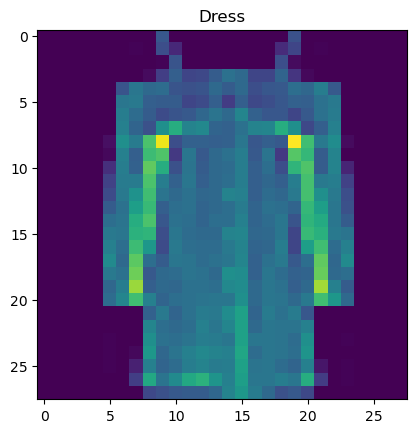

In [50]:
# 随机可视化特征张量
sample_idx = random.randint(1, mnist.targets.size(0))
sample = mnist[sample_idx]
plt.imshow(sample[0].squeeze().numpy())
plt.title(mnist.classes[sample[1]])
plt.show()

In [51]:
# 划分mini-batch
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)
len(loader)

469

In [52]:
# 3.定义神经网络结构
# 输入和输出的大小
input_size = mnist[0][0].numel()  # 1张图片的元素个数，即输入大小
output_size = mnist.targets.unique().size(0)  # 输出大小
input_size, output_size

(784, 10)

In [53]:
# 模型结构
class FashionMNISTModel(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        super().__init__()
        self.in_features = in_features
        self.norm = nn.BatchNorm2d(num_features=1)
        self.linear = nn.Linear(in_features, 128, bias=False)
        self.output = nn.Linear(128, out_features, bias=False)

    def forward(self, x):
        # x = self.norm(x)  # 加入BatchNorm会带来效果提升
        x = x.view(-1, self.in_features)  # 调整特征矩阵的结构：-1表示当前维度会根据其他维度的大小自动计算
        sigma1 = torch.relu(self.linear(x))
        sigma2 = F.log_softmax(self.output(sigma1), dim=-1)
        return sigma2


# 实例化模型
model = FashionMNISTModel(in_features=input_size, out_features=output_size)
model

FashionMNISTModel(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=784, out_features=128, bias=False)
  (output): Linear(in_features=128, out_features=10, bias=False)
)

In [54]:
# 4.5.定义训练函数：定义损失函数和优化器
def fit(model, data_loader, lr=0.01, num_epochs=5, gamma=0):  # 拟合
    criterion = nn.NLLLoss()  # 定义损失函数
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=gamma)  # 定义优化器
    sample_total = len(data_loader.dataset) * num_epochs
    sample_count = 0  # 对样本计数
    correct_count = 0  # 对正确样本计数
    # 6.在epoch和batch上循环迭代
    for epoch in range(1, num_epochs + 1):

        for iteration, (inputs, labels) in enumerate(data_loader, 1):
            # 正向传播
            sigma = model(inputs)
            # 计算损失
            loss = criterion(sigma, labels)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 清空梯度
            optimizer.zero_grad()

            sample_count += labels.size(0)  # 累加样本数
            # 获取模型预测标签
            _, preds = torch.max(sigma, -1)
            correct_count += (preds == labels).sum()  # 累加正确样本数

            if iteration % log_interval == 0 or (iteration == len(data_loader) and epoch == num_epochs):
                # 7.输出结果
                print(
                    f'Epoch:{epoch:0>3}[{sample_count:6d}/{sample_total:6d}({sample_count / sample_total:6.2%})] Loss: {loss.item():.6f} Accuracy: {correct_count / sample_count:.4f}')


#调用函数开始训练
fit(model, loader, lr=lr, num_epochs=num_epochs, gamma=gamma)

Epoch:001[ 12800/600000( 2.13%)] Loss: 0.590182 Accuracy: 0.6774
Epoch:001[ 25600/600000( 4.27%)] Loss: 0.591718 Accuracy: 0.7374
Epoch:001[ 38400/600000( 6.40%)] Loss: 0.452314 Accuracy: 0.7631
Epoch:001[ 51200/600000( 8.53%)] Loss: 0.581987 Accuracy: 0.7786
Epoch:002[ 72800/600000(12.13%)] Loss: 0.419743 Accuracy: 0.7973
Epoch:002[ 85600/600000(14.27%)] Loss: 0.352545 Accuracy: 0.8037
Epoch:002[ 98400/600000(16.40%)] Loss: 0.331535 Accuracy: 0.8102
Epoch:002[111200/600000(18.53%)] Loss: 0.342344 Accuracy: 0.8152
Epoch:003[132800/600000(22.13%)] Loss: 0.246404 Accuracy: 0.8222
Epoch:003[145600/600000(24.27%)] Loss: 0.409624 Accuracy: 0.8258
Epoch:003[158400/600000(26.40%)] Loss: 0.278721 Accuracy: 0.8292
Epoch:003[171200/600000(28.53%)] Loss: 0.297177 Accuracy: 0.8322
Epoch:004[192800/600000(32.13%)] Loss: 0.280937 Accuracy: 0.8362
Epoch:004[205600/600000(34.27%)] Loss: 0.244004 Accuracy: 0.8385
Epoch:004[218400/600000(36.40%)] Loss: 0.361753 Accuracy: 0.8407
Epoch:004[231200/600000(3

可以看到，已经实现了使用真实数据进行模型搭建和训练的完整过程，不使用BatchNorm的效果能够达到87%，加入BatchNorm后模型效果可以提升3%左右，成熟的神经网络架构已经可以在MINST-FASHION数据集上达到99%的精确率，这也是后面进一步努力的方向。